###  K-means with Euclidena distance as proximity measure

In [256]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random as rd

In [257]:
def getEucledian(a,b):
    #print(a,b)
    total = 0;
    for i in range(0,len(a)):
        diff = b[i] - a[i];
        total += diff * diff;
    return np.sqrt(total)

In [258]:
def clusterSSE(x,k_clusters,k_centers):
    total = {} 
    for key,value in k_clusters.items():
        s = 0
        center = k_centers[key]
        for i in value:
            s = s + math.pow(getEucledian(x[i],center),2)
        total[key] = s
    return total       

In [259]:
def overallSSE(cluster_sse):
    s = 0
    for key,value in cluster_sse.items():
        s = s + cluster_sse[key]
    return s

In [260]:
def SSB(x,k_clusters,k_centers):
    total = {}
    keys = list(k_centers.keys())
    for j in keys:
        s =  0
        for i in keys:
            s = s + math.pow(getEucledian(k_centers[i],k_centers[j]),2)
        total[j] = s
    return total

In [261]:
def getMeanUsingIndex(x,indices):
    total = []
    for i in x[0]:
        total.append(0)
    #print(total)
    for i in indices:
        for j in range(0,len(total)):
            total[j] = total[j] + x[i][j]
    total = [f/len(indices) for f in total]
    return (total)

In [262]:
def anyCenterChanged(k_centers,new_centers):
    for key,value in k_centers.items():
        if(k_centers[key] != new_centers[key]):
            return True
    return False

In [263]:
def assignInputToClusters(x,k_centers):
    #keep track of clusters
    k_clusters = {}
    # print("Centers : ")
    # print(k_centers)
    dissimilarity = []
    #assign all input patterns to clusters
    for key,i in k_centers.items():
        for j in x:
            dissimilarity.append(getEucledian(i,j)) #eucledian similarity

    dissimilarity = np.reshape(dissimilarity,(len(k_centers),len(x)))
    df_dissim = pd.DataFrame(data=dissimilarity)
    #print(df_dissim)
    for i in range(1,df_dissim.shape[0]+1):
        k_clusters[i] = [];
    for i in df_dissim.columns:
        #print(df_dissim.nsmallest(1,i).index[0],end = " ")
        shortest_dist_index = df_dissim.nsmallest(1,i).index[0]
        k_clusters[shortest_dist_index+1].append(i)
    #print(k_clusters)
    new_centers = {}
    for key,value in k_clusters.items():
        #print(key,value)
        new_centers[key]  = getMeanUsingIndex(x,value)
#     print("New Centers : ")
#     print(new_centers)
    if(anyCenterChanged(k_centers,new_centers)):
        assignInputToClusters(x,new_centers)
    return (new_centers,k_clusters)

In [264]:
def recomputeDist(x,centers):
    dist = []
    for i in x:
        t = []
        for key,value in centers.items():
            t.append(getEucledian(i,value))
        dist.append(np.min(t))
    total = np.sum(dist)
    prob_dist = [d/total for d in dist]
    return dist,prob_dist

In [265]:
def kMeansPlusPlus(x,K):
    k_centers = {}
    #randomly select one center
    k_centers[1] = rd.sample(x,1)[0]
    print("First center : " + str(k_centers[1]))
    #calculate distance of all points to this center
    dist = []
    for i in x:
        dist.append(getEucledian(i,k_centers[1]))
    total = np.sum(dist)
    #get probability distribution for each point using the distance
    prob_dist = [d/total for d in dist]
    #select k centers using probability distribution
    j = 2
    index = list(range(0,len(x)))
    while(not(len(k_centers) == K)):
        i = np.random.choice(index,p=prob_dist)
        k_centers[j] = x[i]
        dist,prob_dist = recomputeDist(x,k_centers)
        j = j + 1
    return k_centers
    

In [266]:
def kMeans(x,K):
    #select K number of input patterns as cluster centers randomly
    centers = rd.sample(x,K)
    k_centers = kMeansPlusPlus(x,K)
#     k_centers = {}
#     i = 1
#     for j in centers:
#         k_centers[i] = j
#         i = i + 1

    (k_centers,k_clusters) = assignInputToClusters(x,k_centers)
    return (k_clusters,k_centers)


In [267]:
def getOutFrame(k_clusters):
    columns = ["Row ID","Cluster"]
    df_out = pd.DataFrame() 
    for key,values in k_clusters.items():
        t = []
        for i in values:
            t.append(key)
        df = pd.DataFrame({"Row ID" : values, "Cluster" : t})
        df_out = df_out.append(df)
        df_out = df_out.sort_values("Row ID",ascending=True)
#     indices = df_out["Row ID"]
#     indices = [x+1 for x in indices]
#     df_out["Row ID"] = indices
    return df_out

In [268]:
def plotClusters(x,k_clusters,title,xlabel,ylabel):
    fig1 = plt.figure(1)
    for key,value in k_clusters.items():
        c = [x[index] for index in value]
        #print(c)
        plt.scatter(*zip(*c),label="Cluster " + str(key))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [269]:
def getTrueClusters(df):
    k_clusters = {}
    k_centers = {}
    clusters = set(df["cluster"])
    #print(clusters)
    df_temp = df_tdh.drop(["ID","cluster"],axis=1)
    x = df_temp.values.tolist()
    for i in clusters:
        a = df.loc[df['cluster'] == i].index
        #print(a)
        k_clusters[i] = list(a)
        k_centers[i] = getMeanUsingIndex(x,list(a))
    #print(k_clusters)
    return k_clusters,k_centers

In [270]:
# df_tdh = pd.read_csv("wine.csv")
# df_tdh = df_tdh.drop(["ID","quality","class"],axis=1)
df_tdh = pd.read_csv("TwoDimHard.csv")
true_clusters,true_centers = getTrueClusters(df_tdh)
df_tdh = df_tdh.drop(["ID","cluster"],axis=1)
#df_tdh.head()

In [271]:
x = df_tdh.values.tolist()
k = int(input("Enter K : "))
(k_clusters,k_centers) = kMeans(x,k)
print(k_centers)
df_out = getOutFrame(k_clusters)
df_out.to_csv("output.csv")

Enter K : 4
First center : [0.669727238256302, 0.6944743320539339]
{1: [0.6289118989412369, 0.6870771463987936], 2: [0.43654963614282777, 0.33408368358485174], 3: [0.3491201748425923, 0.7489982247226596], 4: [0.7723636884234838, 0.39617944525609916]}


In [272]:
sse = clusterSSE(x,k_clusters,k_centers)
print("Cluster SSE : " + str(sse))
overall_sse = overallSSE(sse)
print("Overall SSE : " + str(overall_sse))
ssb = SSB(x,k_clusters,k_centers)
print("SSB : " + str(ssb))

Cluster SSE : {1: 1.0350257040373592, 2: 1.9239592505891805, 3: 0.9901792627382751, 4: 1.322588174832281}
Overall SSE : 5.2717523921970955
SSB : {1: 0.3489251421889476, 2: 0.45803257341583653, 3: 0.5655317788983013, 4: 0.5254430126950225}


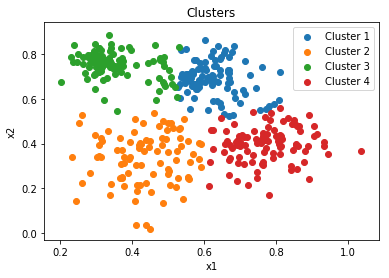

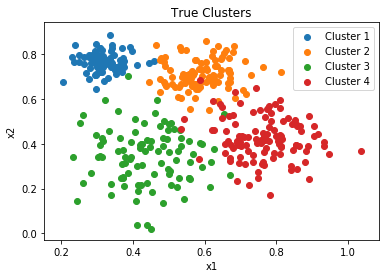

   Cluster  Row ID
0        3       0
1        3       1
2        3       2
3        3       3
4        3       4
True Cluster SSE : {1: 0.31284771797726363, 2: 0.9025336156215499, 3: 2.4301187182254433, 4: 1.910715466347143}
True Overall SSE : 5.5562155181714
True SSB : {1: 0.5792218388564331, 2: 0.3446316577376741, 3: 0.45901679771978393, 4: 0.5321896827999809}


In [273]:
plotClusters(x,k_clusters,"Clusters","x1","x2")
plotClusters(x,true_clusters,"True Clusters","x1","x2")
print(df_out.head())
true_sse = clusterSSE(x,true_clusters,true_centers)
print("True Cluster SSE : " + str(true_sse))
true_overall_sse = overallSSE(true_sse)
print("True Overall SSE : " + str(true_overall_sse))
true_ssb = SSB(x,true_clusters,true_centers)
print("True SSB : " + str(true_ssb))